# 1. Import Necessary Modules

In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
import keras as ks
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation, Dropout, Dense
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import os
import ast
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.style.use('seaborn-whitegrid')
style_dict = {'background-color':'gainsboro', 
              'color':'steelblue', 
              'border-color': 'white', 
              'font-family':'Roboto'}

%matplotlib inline

In [4]:
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
os.listdir()

['.ipynb_checkpoints',
 'doodle-data',
 'doodle-recognition-01.ipynb',
 'model',
 'output-data',
 'transform-data',
 'weight']

In [6]:
files = os.listdir("doodle-data")
file_path = 'doodle-data/'
labels = [el.replace(" ", "_")[:-4] for el in files]

In [7]:
print(sorted(labels))

['The_Eiffel_Tower', 'The_Great_Wall_of_China', 'The_Mona_Lisa', 'pineapple', 'pizza', 'toothbrush', 'toothpaste', 'train', 'washing_machine', 'yoga']


In [22]:
path_pine = 'doodle-data/pineapple.csv'

In [23]:
%time df_pine = pd.read_csv(path_pine, index_col='key_id')

Wall time: 1.17 s


In [24]:
df_pine.tail(3).T.style.set_properties(**style_dict)

key_id,5706553418055680,5259798503227392,5994805534392320
countrycode,US,US,US
drawing,"[[[123, 96, 65, 57, 51, 40, 49, 74, 119, 130, 133, 133, 139, 139, 135, 122], [114, 110, 118, 140, 188, 230, 243, 255, 247, 242, 233, 181, 149, 131, 102, 112]], [[99, 73], [111, 0]], [[101, 118, 127, 111, 118, 103, 107, 105, 90, 92, 78, 78, 70, 67, 68, 61, 62, 67, 70, 70, 65, 65, 76, 81, 83, 89], [104, 80, 60, 81, 53, 73, 59, 43, 75, 47, 84, 66, 51, 87, 70, 55, 79, 85, 76, 64, 54, 67, 100, 105, 89, 108]], [[59, 66, 96, 139], [147, 153, 158, 155]], [[0, 13, 29, 83], [222, 234, 241, 248]]]","[[[37, 24, 17, 5, 3, 8, 28, 54, 79, 94, 101, 132, 144, 152, 157, 153, 137, 129, 87, 42, 16], [255, 236, 208, 179, 162, 111, 41, 11, 0, 0, 3, 33, 54, 80, 146, 164, 204, 214, 241, 244, 233]], [[46, 40, 40, 44, 50, 51], [24, 41, 46, 49, 39, 24]], [[67, 75, 102], [7, 43, 85]], [[45, 74, 110, 127], [79, 52, 28, 11]], [[33, 46, 66, 76], [45, 88, 137, 150]], [[117, 93, 37, 0], [65, 88, 125, 157]], [[8, 31, 65, 80, 91, 91, 85], [147, 187, 227, 236, 237, 229, 221]], [[117, 110, 70, 21, 7, 15], [104, 120, 160, 222, 235, 230]], [[67, 70, 87, 100, 117, 127, 129], [138, 161, 187, 189, 183, 172, 157]]]","[[[81, 54, 38, 31, 18, 18, 23, 36, 61, 91, 107, 124, 133, 134, 117, 98, 85], [80, 88, 105, 119, 165, 229, 241, 249, 255, 254, 240, 212, 180, 138, 103, 83, 79]], [[88, 102, 106, 105, 97, 91, 75], [74, 47, 25, 6, 0, 10, 79]], [[72, 69, 65, 56, 53, 53, 56], [81, 47, 37, 31, 35, 61, 82]], [[53, 51, 32, 1, 0, 12, 37], [82, 72, 45, 18, 36, 69, 88]], [[110, 105, 86], [97, 118, 162]]]"
recognized,True,True,True
timestamp,2017-03-12 18:02:47.043950,2017-03-19 01:35:44.865020,2017-03-12 03:26:29.806430
word,pineapple,pineapple,pineapple


In [15]:
I = 64 # image size in pixels
S = 1 # number of the label set {1,...,10} -> {1-34,..., 307-340}
T = 10 # number of labels in one set 
N = 7000 # number of images with the same label in the training set

In [11]:
# https://stackoverflow.com/questions/25837544/get-all-points-of-a-straight-line-in-python
def get_line(x1, y1, x2, y2):
    points = []
    issteep = abs(y2-y1) > abs(x2-x1)
    if issteep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
    rev = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        rev = True
    deltax = x2 - x1; deltay = abs(y2 - y1)
    error = int(deltax / 2)
    y = y1; ystep = None
    if y1 < y2:
        ystep = 1
    else:
        ystep = -1
    for x in range(x1, x2 + 1):
        if issteep:
            points.append((y, x))
        else:
            points.append((x, y))
        error -= deltay
        if error < 0:
            y += ystep
            error += deltax
    if rev:
        points.reverse()
    return points

In [12]:
def get_image(data, k):
    img = np.zeros((280, 280))
    picture = ast.literal_eval(data.values[k])
    for x,y in picture:
        for i in range(len(x)):
            img[y[i]+10][x[i]+10] = 1
            if (i < len(x)-1):
                x1, y1, x2, y2 = x[i], y[i], x[i+1], y[i+1]
            else:
                x1, y1, x2, y2 = x[i], y[i], x[0], y[0]
            for xl,yl in get_line(x1, y1, x2, y2):
                img[yl+10][xl+10] = 1
                
    return resize(img, (I,I))    

In [122]:
# additional functions
def display_drawing():
    for k in range (10) :  
        plt.figure(figsize=(10,2))
        plt.suptitle(files[(S-1)*T+k])
        for i in range(5):
            picture = ast.literal_eval(data[labels[(S-1)*T+k]].values[i])
            for x,y in picture:
                plt.subplot(1,5,i+1)
                plt.plot(x, y, '-o', color='gainsboro')
                plt.xticks([]); plt.yticks([])
            plt.gca().invert_yaxis()
            plt.axis('equal');

In [123]:
data = pd.DataFrame(index=range(N), columns=labels[(S-1)*T:S*T])

In [124]:
data.head()

,pineapple,pizza,The_Eiffel_Tower,The_Great_Wall_of_China,The_Mona_Lisa,toothbrush,toothpaste,train,washing_machine,yoga
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
for i in range((S-1)*T,S*T):
    data[labels[i]] = pd.read_csv(file_path + files[i], index_col='key_id') \
    .drawing.values[:N]
data.shape

(7000, 10)

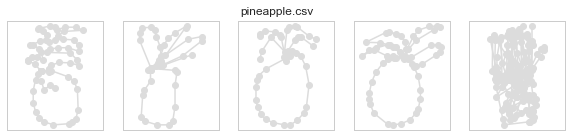

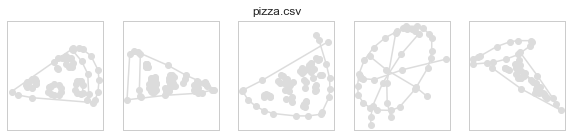

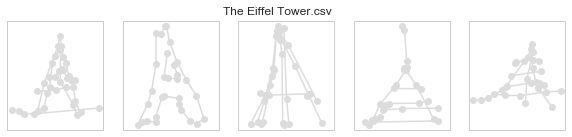

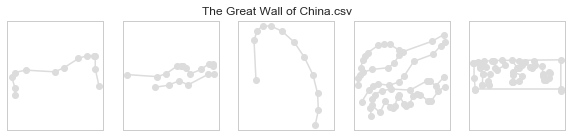

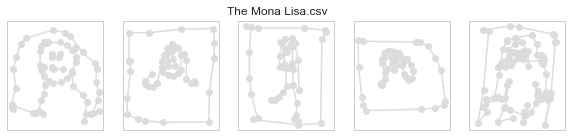

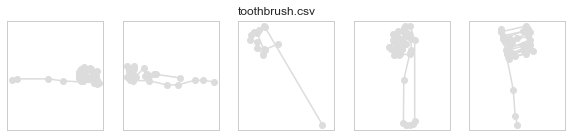

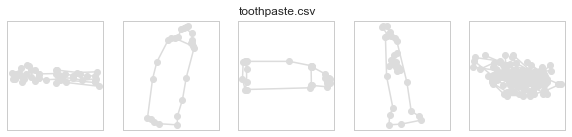

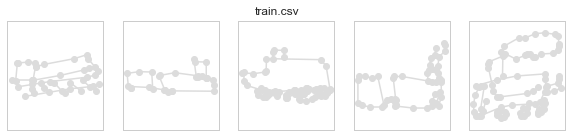

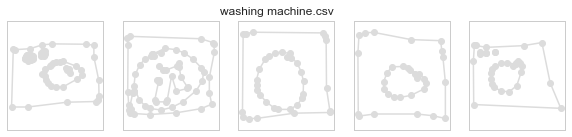

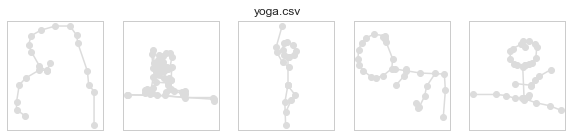

In [126]:
display_drawing()

In [20]:
data.head()

,pineapple,pizza,The_Eiffel_Tower,The_Great_Wall_of_China,The_Mona_Lisa,toothbrush,toothpaste,train,washing_machine,yoga
0,"[[[33, 33], [117, 117]], [[33, 26, 20, 14, 14,...","[[[147, 123, 0, 18, 61, 236, 243, 252, 255, 25...","[[[0, 22, 37, 64, 255], [218, 220, 227, 228, 2...","[[[10, 41, 126, 153, 195, 219, 241], [49, 42, ...","[[[101, 98, 91, 83, 80, 80, 82, 92, 104, 117, ...","[[[0, 15, 107, 149, 244, 254, 249], [38, 34, 3...","[[[130, 129, 159, 254, 248, 191, 133], [15, 53...","[[[17, 12], [24, 76]], [[18, 47, 69, 70, 63], ...","[[[5, 0, 48, 162, 247, 253, 255, 254, 240, 240...","[[[79, 59, 38, 31, 38, 62, 100, 138, 155, 158,..."
1,"[[[28, 28, 12, 8, 4, 15, 45, 75, 85, 91, 91, 9...","[[[8, 0, 112, 219], [8, 142, 129, 122]], [[20,...","[[[47, 47, 36, 26, 0, 10, 23, 46, 46, 63, 68, ...","[[[0, 88, 115, 146, 156, 164, 173, 184, 216, 2...","[[[7, 9, 1, 0, 31, 49, 98, 222, 223, 236, 237,...","[[[255, 223, 199, 149, 118, 64, 17, 9, 1, 1, 6...","[[[8, 17, 29, 77, 77, 90, 100, 120, 117, 72, 6...","[[[195, 202], [0, 51]], [[197, 231, 231, 219, ...","[[[12, 5, 2, 3, 0, 8, 215, 250, 253, 255, 240,...","[[[255, 90, 4], [141, 130, 128]], [[254, 252, ..."
2,"[[[89, 27, 7, 3, 0, 0, 4, 13, 26, 43, 73, 89, ...","[[[0, 16, 39, 64, 90, 155, 192, 230], [163, 18...","[[[184, 115, 67, 57, 36, 18], [251, 103, 12, 1...","[[[5, 0, 8, 22, 44, 73, 104, 130, 152, 164, 16...","[[[12, 8, 8, 13, 29], [3, 66, 134, 176, 238]],...","[[[37, 187], [0, 255]], [[39, 24, 19, 35, 39, ...","[[[2, 0, 8, 12, 12, 9, 6], [3, 53, 84, 62, 24,...","[[[0, 32, 66, 69, 70, 229, 244, 255, 254, 250,...","[[[2, 0, 3, 19, 43, 151, 254, 255, 245, 244, 2...","[[[30, 22, 24], [152, 197, 255]], [[29, 48, 39..."
3,"[[[82, 66, 54, 35, 24, 18, 18, 20, 30, 66, 80,...","[[[147, 139, 127, 101, 71, 41, 17, 4, 0, 2, 14...","[[[0, 187, 177, 132, 105, 79, 38, 19, 11], [24...","[[[1, 1, 6, 16, 43, 89, 106, 120, 133, 217, 25...","[[[0, 2, 11, 14, 24, 184, 225, 252, 255, 243, ...","[[[36, 25, 12, 22, 21, 11, 13, 0, 5, 14, 13, 2...","[[[8, 11, 27, 19, 17, 49, 99, 93, 74, 63, 37, ...","[[[103, 112], [103, 182]], [[104, 129, 215, 24...","[[[245, 254, 254, 218, 171, 48, 3, 1, 0, 3, 21...","[[[78, 78, 46, 23, 11, 2, 0, 4, 16, 39, 52, 73..."
4,"[[[36, 101, 109, 111, 112, 103, 97, 73, 36, 15...","[[[15, 69, 108, 130, 168, 171, 166, 132, 95, 5...","[[[0, 21, 43, 83, 97, 158, 169, 172], [162, 16...","[[[2, 2, 6], [8, 52, 87]], [[0, 53, 255, 255],...","[[[87, 69, 63, 53, 42, 59, 68, 74, 78, 70, 83,...","[[[1, 32, 37, 43], [8, 164, 231, 255]], [[0, 6...","[[[255, 209, 176, 146, 99, 88, 57, 53, 56, 86,...","[[[9, 70, 127, 209], [154, 137, 126, 120]], [[...","[[[3, 0, 1, 254, 223, 199, 146, 36, 7], [8, 53...","[[[150, 140, 115, 108, 107, 118, 126, 151, 162..."


In [29]:
images = []

for label in labels[(S-1)*T:S*T]:
    images.extend([get_image(data[label], i) for i in range(N)])
    
images = np.array(images)
del data, df_pine 

images.shape

(70000, 64, 64)

In [30]:
targets = np.array([[] + N * [k] for k in range(T)])
targets = ks.utils.to_categorical(targets, T).reshape(N*T,T)
targets.shape

(70000, 10)

In [31]:
import h5py

In [32]:
with h5py.File('transform-data/QuickDrawImages001-010.h5', 'w') as f:
    f.create_dataset('images', data=images)
    f.create_dataset('targets', data=targets)
    f.close()

In [33]:
x_train, x_test, y_train, y_test = \
train_test_split(images, targets, test_size = 0.2, random_state = 1)

n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]

del images, targets

x_train = x_train.reshape(-1,I,I,1)
x_valid = x_valid.reshape(-1,I,I,1)
x_test = x_test.reshape(-1,I,I,1)
y_train.shape, y_valid.shape, y_test.shape

((56000, 10), (7000, 10), (7000, 10))

In [34]:
def model():
    model = Sequential()
    
    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(196, (5, 5)))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 
    
    model.add(Dense(T))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [35]:
model = model()

In [197]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 196)       156996    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 196)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 196)       0         
__________

In [36]:
checkpointer = \
ModelCheckpoint(filepath='weight/weights.best.model.hdf5', verbose=1, save_best_only=True)
lr_reduction = \
ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=2, factor=0.5)

In [37]:
history = model.fit(x_train, y_train, 
                    epochs=100, batch_size=50, verbose=1,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpointer, lr_reduction])

Train on 56000 samples, validate on 7000 samples
Epoch 1/100
56000/56000 [==============================] - 104s 2ms/step - loss: 1.3246 - acc: 0.5289 - val_loss: 0.9810 - val_acc: 0.6730

Epoch 00001: val_loss improved from inf to 0.98104, saving model to weight/weights.best.model.hdf5
Epoch 2/100
56000/56000 [==============================] - 86s 2ms/step - loss: 0.9275 - acc: 0.6827 - val_loss: 0.8912 - val_acc: 0.7111

Epoch 00002: val_loss improved from 0.98104 to 0.89117, saving model to weight/weights.best.model.hdf5
Epoch 3/100
56000/56000 [==============================] - 86s 2ms/step - loss: 0.8228 - acc: 0.7187 - val_loss: 0.8009 - val_acc: 0.7336

Epoch 00003: val_loss improved from 0.89117 to 0.80088, saving model to weight/weights.best.model.hdf5
Epoch 4/100
56000/56000 [==============================] - 87s 2ms/step - loss: 0.7528 - acc: 0.7447 - val_loss: 0.7402 - val_acc: 0.7544

Epoch 00004: val_loss improved from 0.80088 to 0.74018, saving model to weight/weights.be

56000/56000 [==============================] - 89s 2ms/step - loss: 0.3351 - acc: 0.8846 - val_loss: 0.5786 - val_acc: 0.8179

Epoch 00039: val_loss did not improve from 0.57479
Epoch 40/100
56000/56000 [==============================] - 89s 2ms/step - loss: 0.3281 - acc: 0.8877 - val_loss: 0.5920 - val_acc: 0.8084

Epoch 00040: val_loss did not improve from 0.57479
Epoch 41/100
56000/56000 [==============================] - 89s 2ms/step - loss: 0.3261 - acc: 0.8885 - val_loss: 0.5877 - val_acc: 0.8137

Epoch 00041: val_loss did not improve from 0.57479
Epoch 42/100
56000/56000 [==============================] - 89s 2ms/step - loss: 0.3239 - acc: 0.8887 - val_loss: 0.6072 - val_acc: 0.8079

Epoch 00042: val_loss did not improve from 0.57479

Epoch 00042: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 43/100
56000/56000 [==============================] - 89s 2ms/step - loss: 0.3000 - acc: 0.8976 - val_loss: 0.5918 - val_acc: 0.8194

Epoch 00043: val_loss did no


Epoch 00078: val_loss did not improve from 0.57479
Epoch 79/100
56000/56000 [==============================] - 89s 2ms/step - loss: 0.2492 - acc: 0.9158 - val_loss: 0.5932 - val_acc: 0.8210

Epoch 00079: val_loss did not improve from 0.57479
Epoch 80/100
56000/56000 [==============================] - 89s 2ms/step - loss: 0.2442 - acc: 0.9150 - val_loss: 0.5926 - val_acc: 0.8210

Epoch 00080: val_loss did not improve from 0.57479
Epoch 81/100
56000/56000 [==============================] - 99s 2ms/step - loss: 0.2479 - acc: 0.9142 - val_loss: 0.5937 - val_acc: 0.8207

Epoch 00081: val_loss did not improve from 0.57479
Epoch 82/100
56000/56000 [==============================] - 99s 2ms/step - loss: 0.2473 - acc: 0.9152 - val_loss: 0.5931 - val_acc: 0.8204

Epoch 00082: val_loss did not improve from 0.57479

Epoch 00082: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 83/100
56000/56000 [==============================] - 99s 2ms/step - loss: 0.2435 - acc: 0.9164 -

In [42]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


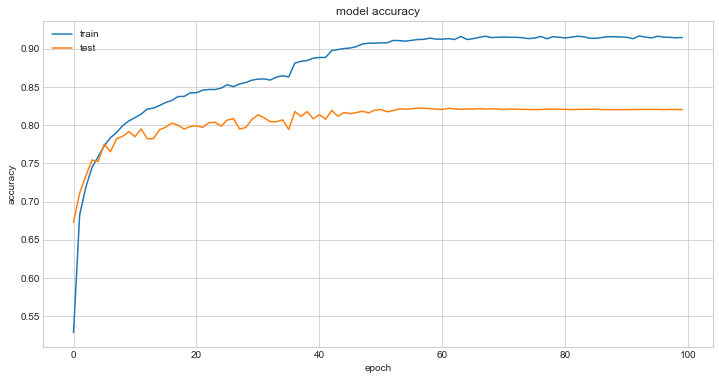

In [44]:
# summarize history for accuracy
plt.figure(figsize=(12,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

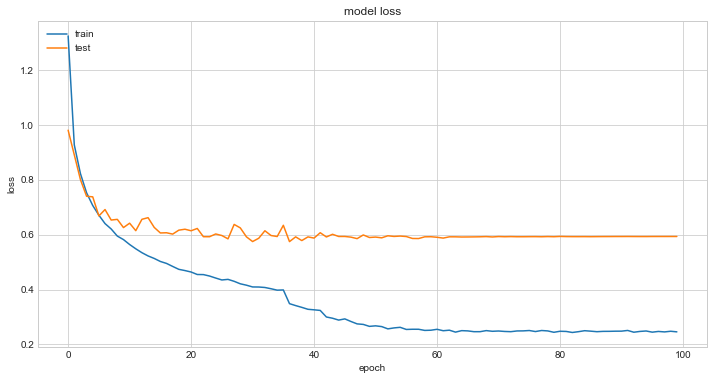

In [45]:
# summarize history for loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [147]:
model.save_weights('model/model1.h5')

In [55]:
x_test.shape, y_test.shape

((7000, 64, 64, 1), (7000, 10))

In [53]:
predicted = model.predict(x_test)

In [62]:
predicted[0]

array([1.80599020e-08, 1.17421514e-07, 5.87919487e-07, 1.42211880e-04,
       9.10699666e-02, 2.17253751e-06, 1.51712709e-06, 8.54297522e-09,
       9.08625424e-01, 1.57938397e-04], dtype=float32)

In [64]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [47]:
import itertools

In [57]:
class_names = np.array(labels)

In [58]:
class_names

array(['pineapple', 'pizza', 'The_Eiffel_Tower',
       'The_Great_Wall_of_China', 'The_Mona_Lisa', 'toothbrush',
       'toothpaste', 'train', 'washing_machine', 'yoga'], dtype='<U23')

In [73]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), predicted.argmax(axis=1))
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[689   5   2   1   1   5   5   6   0  34]
 [ 13 651  12   3   5   6  12   1   4  30]
 [  7   2 690   3   1   6   7   1   1  31]
 [  5   4   3 426   1  64  65  51   3  35]
 [  6  10   9   4 557   9  18   5  46  39]
 [  2   0   4  27   0 594  44  10   3  14]
 [  1   3   8  50   5  56 477  15   2  34]
 [  1   3   0  30   2  13  41 547   3  50]
 [  0   3   1   2  34   1  12   6 583  22]
 [ 18   7  17  13   5  12  44  23  11 553]]


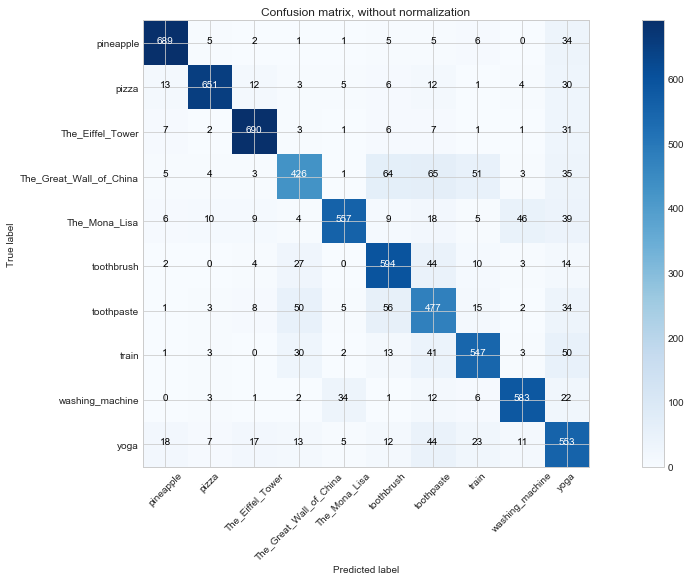

In [71]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(15,8))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.92 0.01 0.   0.   0.   0.01 0.01 0.01 0.   0.05]
 [0.02 0.88 0.02 0.   0.01 0.01 0.02 0.   0.01 0.04]
 [0.01 0.   0.92 0.   0.   0.01 0.01 0.   0.   0.04]
 [0.01 0.01 0.   0.65 0.   0.1  0.1  0.08 0.   0.05]
 [0.01 0.01 0.01 0.01 0.79 0.01 0.03 0.01 0.07 0.06]
 [0.   0.   0.01 0.04 0.   0.85 0.06 0.01 0.   0.02]
 [0.   0.   0.01 0.08 0.01 0.09 0.73 0.02 0.   0.05]
 [0.   0.   0.   0.04 0.   0.02 0.06 0.79 0.   0.07]
 [0.   0.   0.   0.   0.05 0.   0.02 0.01 0.88 0.03]
 [0.03 0.01 0.02 0.02 0.01 0.02 0.06 0.03 0.02 0.79]]


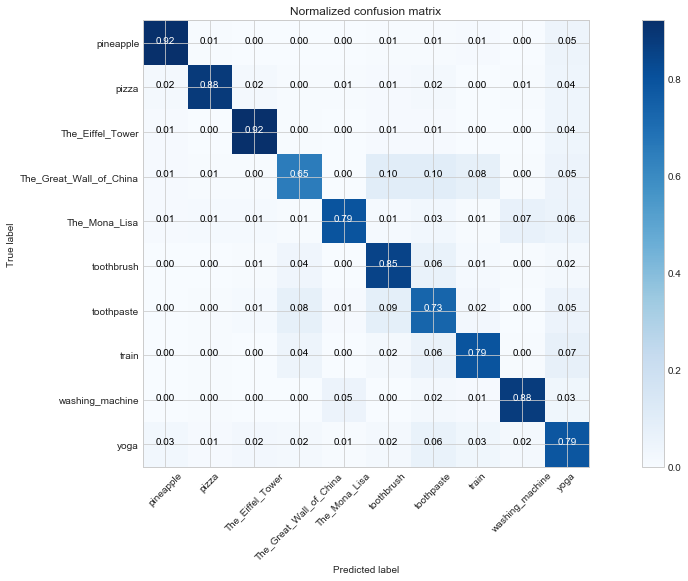

In [72]:
# Plot normalized confusion matrix
plt.figure(figsize=(15,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [90]:
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(predicted, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 

In [98]:
Y_pred_classes

array([8, 3, 8, ..., 0, 7, 4], dtype=int64)

In [93]:
Y_pred_classes.shape, Y_true.shape

((7000,), (7000,))

In [96]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)
errors

array([False,  True, False, ..., False, False, False])

In [97]:
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_classes_errors

array([3, 0, 3, ..., 6, 0, 4], dtype=int64)

In [99]:
Y_pred_errors = predicted[errors]
Y_pred_errors

array([[8.90e-07, 4.28e-08, 4.53e-06, ..., 7.24e-04, 9.67e-07, 8.97e-06],
       [7.60e-01, 6.94e-07, 7.81e-09, ..., 1.39e-05, 4.70e-10, 2.40e-01],
       [3.14e-06, 3.89e-06, 1.06e-03, ..., 4.59e-03, 1.00e-01, 3.34e-03],
       ...,
       [1.26e-04, 2.08e-05, 2.01e-01, ..., 1.00e-06, 4.46e-06, 3.10e-03],
       [6.67e-01, 5.03e-04, 1.04e-05, ..., 1.80e-05, 1.05e-03, 3.30e-01],
       [2.00e-03, 2.31e-04, 4.63e-03, ..., 2.86e-01, 5.99e-02, 7.57e-02]],
      dtype=float32)

In [100]:
Y_true_errors = Y_true[errors]
Y_true_errors

array([9, 4, 4, ..., 4, 9, 7], dtype=int64)

In [102]:
x_test_errors = x_test[errors]

In [116]:
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 9 images with their predicted and real labels"""
    n = 0
    nrows = 3
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15,15))
    
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((64,64)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

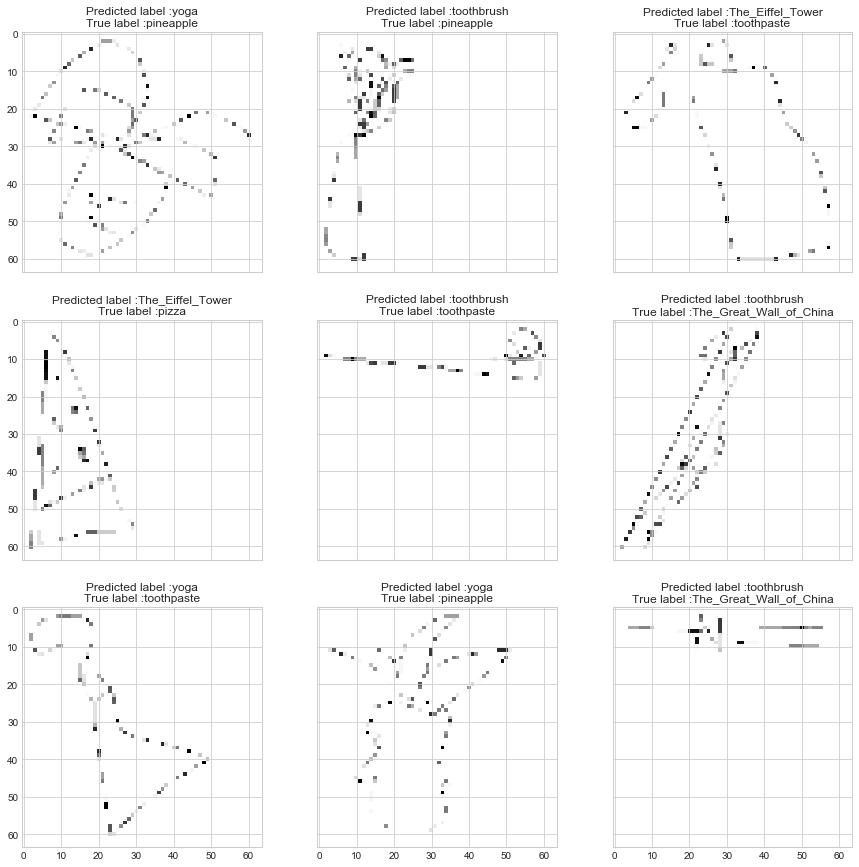

In [121]:
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-9:]

# Show the top 6 errors
display_errors(most_important_errors, x_test_errors, class_names[Y_pred_classes_errors], class_names[Y_true_errors])

## Next Step ลอง Data Augmentation ดู

In [128]:
def model2():
    model = Sequential()
    
    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(196, (5, 5)))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 
    
    model.add(Dense(T))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [129]:
model2 = model2()

In [131]:
from keras.preprocessing.image import ImageDataGenerator

In [132]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [133]:
checkpointer = \
ModelCheckpoint(filepath='weight/weights2.best.model.hdf5', verbose=1, save_best_only=True)
lr_reduction = \
ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=2, factor=0.5)

In [135]:
# Fit model
datagen.fit(x_train)

In [136]:
history2 = model2.fit_generator(datagen.flow(x_train, y_train, 
	batch_size=50), epochs = 40, validation_data=(x_valid, y_valid),
	verbose = 1, callbacks=[checkpointer, lr_reduction])

Epoch 1/40
1120/1120 [==============================] - 85s 76ms/step - loss: 1.5500 - acc: 0.4422 - val_loss: 1.4165 - val_acc: 0.5240

Epoch 00001: val_loss improved from inf to 1.41648, saving model to weight/weights2.best.model.hdf5
Epoch 2/40
1120/1120 [==============================] - 85s 75ms/step - loss: 1.1241 - acc: 0.6048 - val_loss: 1.0061 - val_acc: 0.6536

Epoch 00002: val_loss improved from 1.41648 to 1.00615, saving model to weight/weights2.best.model.hdf5
Epoch 3/40
1120/1120 [==============================] - 85s 76ms/step - loss: 1.0161 - acc: 0.6461 - val_loss: 0.9108 - val_acc: 0.6867

Epoch 00003: val_loss improved from 1.00615 to 0.91081, saving model to weight/weights2.best.model.hdf5
Epoch 4/40
1120/1120 [==============================] - 86s 77ms/step - loss: 0.9550 - acc: 0.6690 - val_loss: 0.8582 - val_acc: 0.7071

Epoch 00004: val_loss improved from 0.91081 to 0.85822, saving model to weight/weights2.best.model.hdf5
Epoch 5/40
1120/1120 [==================

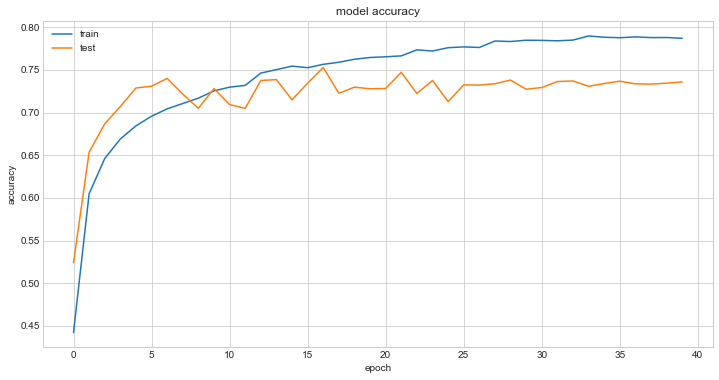

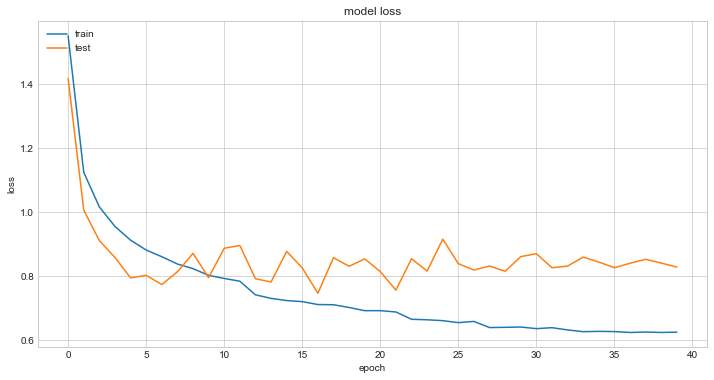

In [137]:
# summarize history for accuracy
plt.figure(figsize=(12,6))
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.figure(figsize=(12,6))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [146]:
model2.save_weights('model/model2.h5')

## ณ ตอนนี้ เปรียบเทียบ 1 vs 2
### เทียบที่ 40 epoch 
- No DataAugmentation: 

loss: 0.3261 - acc: 0.8885 - val_loss: 0.5877 - val_acc: 0.8137

- DataAugmentation: 

loss: 0.6248 - acc: 0.7869 - val_loss: 0.8280 - val_acc: 0.7359

## ลอง Experiment 3 New Data Gen Tunning

In [138]:
def model3():
    model = Sequential()
    
    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(196, (5, 5)))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 
    
    model.add(Dense(T))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [139]:
model3 = model3()

In [140]:
datagen3 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

In [141]:
checkpointer = \
ModelCheckpoint(filepath='weight/weights3.best.model.hdf5', verbose=1, save_best_only=True)
lr_reduction = \
ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=2, factor=0.5)

In [142]:
datagen3.fit(x_train)

In [148]:
history3 = model3.fit_generator(datagen3.flow(x_train, y_train,
        batch_size=50), epochs = 40, validation_data=(x_valid, y_valid),
        verbose = 1, callbacks=[checkpointer, lr_reduction])

Epoch 1/40
1120/1120 [==============================] - 84s 75ms/step - loss: 1.2562 - acc: 0.5577 - val_loss: 1.1934 - val_acc: 0.6283

Epoch 00001: val_loss did not improve from 0.75446
Epoch 2/40
1120/1120 [==============================] - 85s 76ms/step - loss: 1.1726 - acc: 0.5886 - val_loss: 1.1321 - val_acc: 0.6324

Epoch 00002: val_loss did not improve from 0.75446
Epoch 3/40
1120/1120 [==============================] - 85s 76ms/step - loss: 1.1364 - acc: 0.6026 - val_loss: 1.4029 - val_acc: 0.5809

Epoch 00003: val_loss did not improve from 0.75446
Epoch 4/40
1120/1120 [==============================] - 86s 77ms/step - loss: 1.1102 - acc: 0.6105 - val_loss: 1.1112 - val_acc: 0.6476

Epoch 00004: val_loss did not improve from 0.75446
Epoch 5/40
1120/1120 [==============================] - 86s 77ms/step - loss: 1.0916 - acc: 0.6193 - val_loss: 1.2483 - val_acc: 0.6137

Epoch 00005: val_loss did not improve from 0.75446
Epoch 6/40
1120/1120 [==============================] - 86s 

In [149]:
model3.save_weights('model/model3.h5')

### เทียบที่ 40 epoch
- No DataAugmentation:

loss: 0.3261 - acc: 0.8885 - val_loss: 0.5877 - val_acc: 0.8137

- DataAugmentation:

loss: 0.6248 - acc: 0.7869 - val_loss: 0.8280 - val_acc: 0.7359

- More DataAugmentation:

loss: 0.9587 - acc: 0.6662 - val_loss: 1.3119 - val_acc: 0.5993

In [158]:
from keras import optimizers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau

In [159]:
def model4():
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=x_train.shape[1:]))
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.20))
    
    model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(T, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

In [160]:
model4 = model4()

In [174]:
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 30, 30, 64)        18496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 30, 30, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 64)        0         
__________

In [161]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
checkpointer = ModelCheckpoint(filepath='weight/weights4.best.model.hdf5', verbose=1, save_best_only=True)

In [163]:
history4 = model4.fit(x_train, y_train, 
                    epochs=40, batch_size=64, verbose=1,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpointer, learning_rate_reduction])

Train on 56000 samples, validate on 7000 samples
Epoch 1/40
56000/56000 [==============================] - 73s 1ms/step - loss: 0.6648 - acc: 0.7842 - val_loss: 0.5093 - val_acc: 0.8360

Epoch 00001: val_loss improved from inf to 0.50931, saving model to weight/weights4.best.model.hdf5
Epoch 2/40
56000/56000 [==============================] - 72s 1ms/step - loss: 0.5012 - acc: 0.8400 - val_loss: 0.4579 - val_acc: 0.8550

Epoch 00002: val_loss improved from 0.50931 to 0.45785, saving model to weight/weights4.best.model.hdf5
Epoch 3/40
56000/56000 [==============================] - 72s 1ms/step - loss: 0.4280 - acc: 0.8654 - val_loss: 0.4266 - val_acc: 0.8653

Epoch 00003: val_loss improved from 0.45785 to 0.42657, saving model to weight/weights4.best.model.hdf5
Epoch 4/40
56000/56000 [==============================] - 74s 1ms/step - loss: 0.3791 - acc: 0.8810 - val_loss: 0.4147 - val_acc: 0.8737

Epoch 00004: val_loss improved from 0.42657 to 0.41466, saving model to weight/weights4.bes


Epoch 00040: val_loss did not improve from 0.37588


In [164]:
model4.save_weights('model/model4.h5')

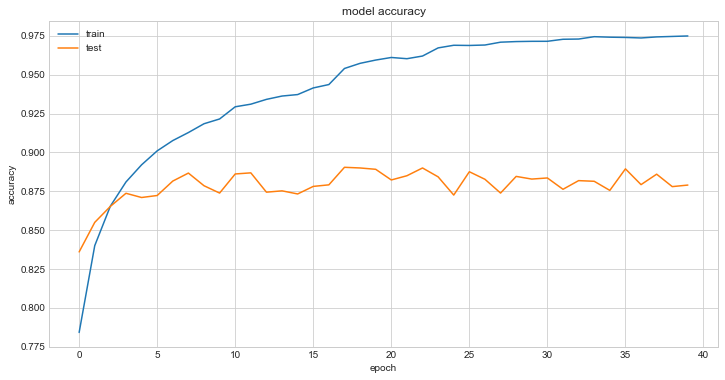

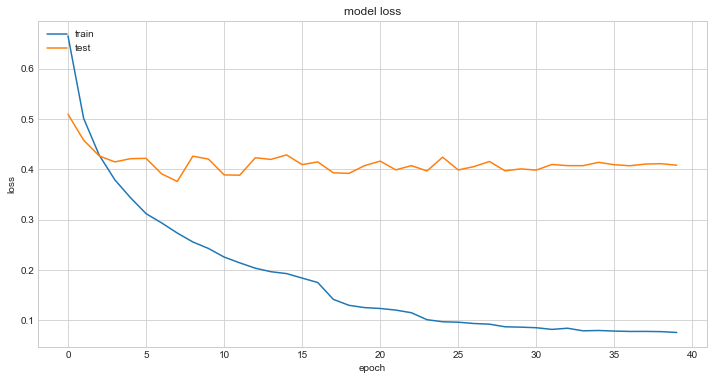

In [165]:
# summarize history for accuracy
plt.figure(figsize=(12,6))
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.figure(figsize=(12,6))
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Confusion matrix, without normalization
[[720   5   2   4   0   3   4   2   0   8]
 [  2 688   7   7   7   4  11   1   2   8]
 [  1   1 719   3   0   2   8   4   2   9]
 [  2   5   2 511   2  28  46  45   1  15]
 [  0   9   4   8 646   2   6   0  18  10]
 [  1   1   1  23   0 614  42  10   0   6]
 [  3   4   9  50   2  32 519   7   2  23]
 [  2   2   0  46   0  14  11 600   0  15]
 [  0   4   0   3  26   1   5   0 619   6]
 [ 14  15  17  22   6  14  30  20   7 558]]
Normalized confusion matrix
[[0.96 0.01 0.   0.01 0.   0.   0.01 0.   0.   0.01]
 [0.   0.93 0.01 0.01 0.01 0.01 0.01 0.   0.   0.01]
 [0.   0.   0.96 0.   0.   0.   0.01 0.01 0.   0.01]
 [0.   0.01 0.   0.78 0.   0.04 0.07 0.07 0.   0.02]
 [0.   0.01 0.01 0.01 0.92 0.   0.01 0.   0.03 0.01]
 [0.   0.   0.   0.03 0.   0.88 0.06 0.01 0.   0.01]
 [0.   0.01 0.01 0.08 0.   0.05 0.8  0.01 0.   0.04]
 [0.   0.   0.   0.07 0.   0.02 0.02 0.87 0.   0.02]
 [0.   0.01 0.   0.   0.04 0.   0.01 0.   0.93 0.01]
 [0.02 0.02 0.02 0.03 0.

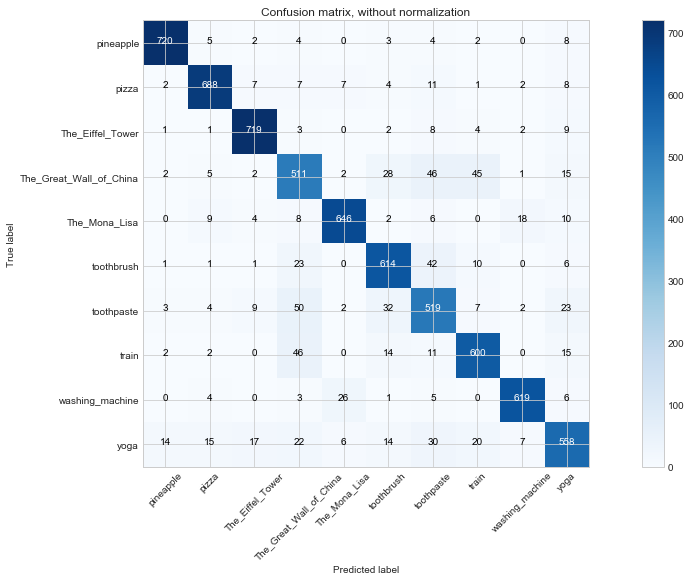

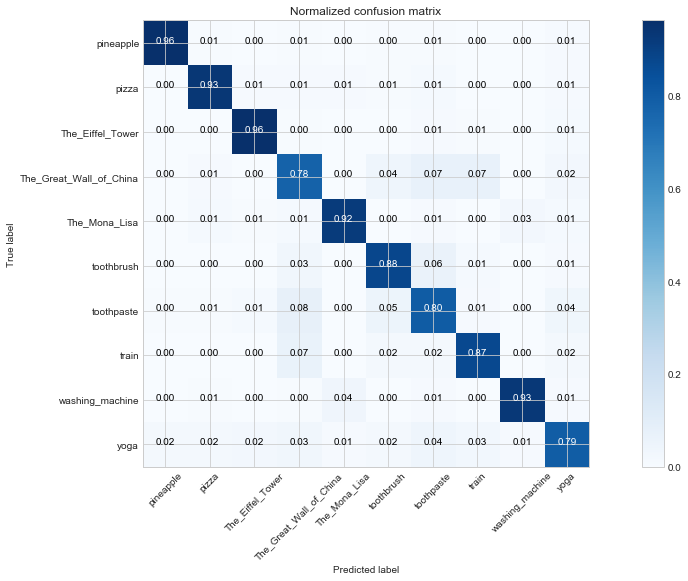

In [166]:
predicted = model4.predict(x_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), predicted.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,8))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [167]:
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(predicted, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
errors = (Y_pred_classes - Y_true != 0)
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = predicted[errors]
Y_true_errors = Y_true[errors]
x_test_errors = x_test[errors]

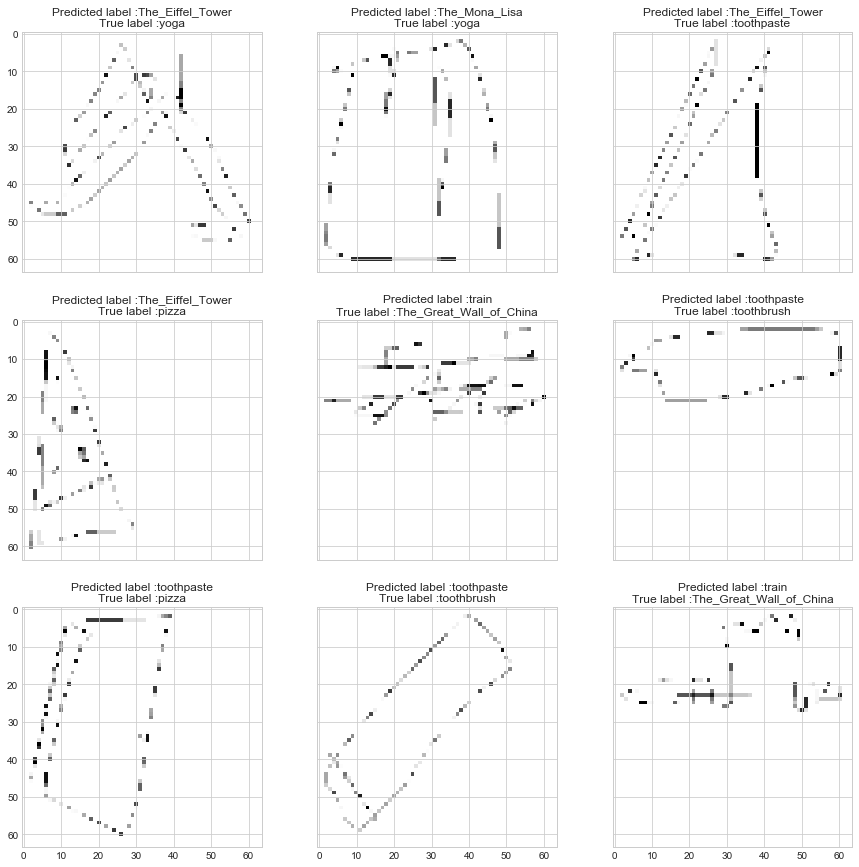

In [168]:
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-9:]

# Show the top 6 errors
display_errors(most_important_errors, x_test_errors, class_names[Y_pred_classes_errors], class_names[Y_true_errors])

## Very well for Improvement Model
### We can tuning more better Result in the next path

- No DataAugmentation:

loss: 0.3261 - acc: 0.8885 - val_loss: 0.5877 - val_acc: 0.8137

- DataAugmentation:

loss: 0.6248 - acc: 0.7869 - val_loss: 0.8280 - val_acc: 0.7359

- More DataAugmentation:

loss: 0.9587 - acc: 0.6662 - val_loss: 1.3119 - val_acc: 0.5993

- New Model 5 Hidden Layers:

loss: 0.0758 - acc: 0.9749 - val_loss: 0.4081 - val_acc: 0.8790

In [188]:
from keras.applications import VGG16
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

In [185]:
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

In [177]:
from keras import layers

In [189]:
def model5():
    model = Sequential()
    
    # Add the vgg convolutional base model
    model.add(ZeroPadding2D((1,1),input_shape=x_train.shape[1:]))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(T, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

In [190]:
model5 = model5()

In [191]:
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 66, 66, 1)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 64)        640       
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 66, 66, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 128)       73856     
__________

In [192]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
checkpointer = ModelCheckpoint(filepath='weight/weights5.best.model.hdf5', verbose=1, save_best_only=True)

In [195]:
history5 = model5.fit(x_train, y_train, 
                    epochs=40, batch_size=32, verbose=1,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpointer, learning_rate_reduction])

Train on 56000 samples, validate on 7000 samples
Epoch 1/40
56000/56000 [==============================] - 521s 9ms/step - loss: 14.4923 - acc: 0.1009 - val_loss: 14.5247 - val_acc: 0.0989

Epoch 00001: val_loss improved from inf to 14.52471, saving model to weight/weights5.best.model.hdf5
Epoch 2/40
56000/56000 [==============================] - 519s 9ms/step - loss: 14.4916 - acc: 0.1009 - val_loss: 14.5247 - val_acc: 0.0989

Epoch 00002: val_loss did not improve from 14.52471
Epoch 3/40
56000/56000 [==============================] - 520s 9ms/step - loss: 14.4916 - acc: 0.1009 - val_loss: 14.5247 - val_acc: 0.0989

Epoch 00003: val_loss did not improve from 14.52471
Epoch 4/40
56000/56000 [==============================] - 522s 9ms/step - loss: 14.4916 - acc: 0.1009 - val_loss: 14.5247 - val_acc: 0.0989

Epoch 00004: val_loss did not improve from 14.52471
Epoch 5/40
56000/56000 [==============================] - 524s 9ms/step - loss: 14.4916 - acc: 0.1009 - val_loss: 14.5247 - val_ac

KeyboardInterrupt: 

## Model ที่ Complex จนเกินไปก็ไม่ได้จดจำอะไรได้เลย !!
### เน้นมา Tuning ตัว Model4 ดีกว่า !!

In [198]:
def model6():
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=x_train.shape[1:]))
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.20))
    
    model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(Dropout(0.25))

    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(T, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

In [199]:
model6 = model6()

In [200]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
checkpointer = ModelCheckpoint(filepath='weight/weights6.best.model.hdf5', verbose=1, save_best_only=True)

In [203]:
history6 = model6.fit(x_train, y_train, 
                    epochs=40, batch_size=64, verbose=1,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpointer, learning_rate_reduction])

Train on 56000 samples, validate on 7000 samples
Epoch 1/40
56000/56000 [==============================] - 81s 1ms/step - loss: 0.8126 - acc: 0.7335 - val_loss: 0.5679 - val_acc: 0.8191

Epoch 00001: val_loss improved from inf to 0.56789, saving model to weight/weights6.best.model.hdf5
Epoch 2/40
56000/56000 [==============================] - 78s 1ms/step - loss: 0.5044 - acc: 0.8408 - val_loss: 0.4603 - val_acc: 0.8539

Epoch 00002: val_loss improved from 0.56789 to 0.46027, saving model to weight/weights6.best.model.hdf5
Epoch 3/40
56000/56000 [==============================] - 79s 1ms/step - loss: 0.4173 - acc: 0.8694 - val_loss: 0.4080 - val_acc: 0.8723

Epoch 00003: val_loss improved from 0.46027 to 0.40799, saving model to weight/weights6.best.model.hdf5
Epoch 4/40
56000/56000 [==============================] - 79s 1ms/step - loss: 0.3681 - acc: 0.8853 - val_loss: 0.3825 - val_acc: 0.8810

Epoch 00004: val_loss improved from 0.40799 to 0.38251, saving model to weight/weights6.bes


Epoch 00040: val_loss did not improve from 0.35571


In [204]:
model6.save_weights('model/model6.h5')

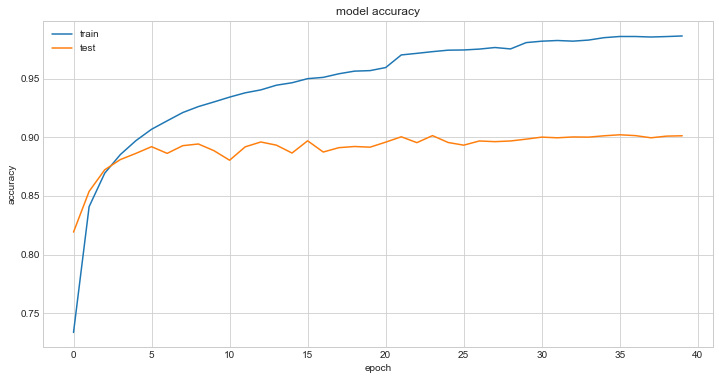

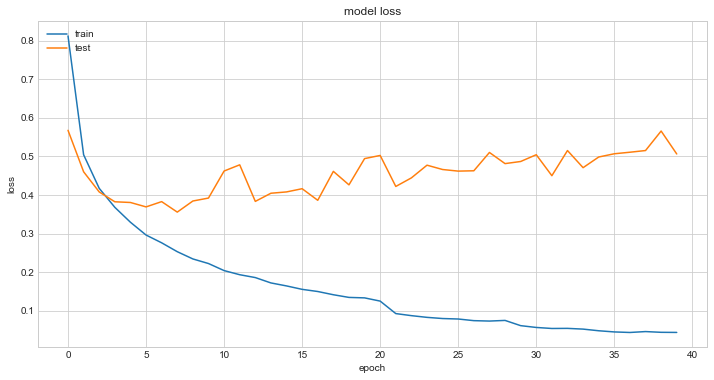

In [210]:
# summarize history for accuracy
plt.figure(figsize=(12,6))
plt.plot(history6.history['acc'])
plt.plot(history6.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.figure(figsize=(12,6))
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Atleast we add more one layer (try 6 hidden layer) Improvement Model
### We can tuning more better Result in the next path

- No DataAugmentation:

loss: 0.3261 - acc: 0.8885 - val_loss: 0.5877 - val_acc: 0.8137

- DataAugmentation:

loss: 0.6248 - acc: 0.7869 - val_loss: 0.8280 - val_acc: 0.7359

- More DataAugmentation:

loss: 0.9587 - acc: 0.6662 - val_loss: 1.3119 - val_acc: 0.5993

- New Model 5 Hidden Layers:

loss: 0.0758 - acc: 0.9749 - val_loss: 0.4081 - val_acc: 0.8790

- VGG16 Model: Failed

loss: 14.4916 - acc: 0.1009 - val_loss: 14.5247 - val_acc: 0.098

- New Model 6 Hidden Layers:

loss: 0.0436 - acc: 0.9864 - val_loss: 0.5065 - val_acc: 0.9013

In [206]:
def model7():
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=x_train.shape[1:]))
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.20))
    
    model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(Dropout(0.25))

    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(T, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

In [207]:
model7 = model7()

In [208]:
model7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 30, 30, 64)        18496     
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 30, 30, 64)        36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 15, 15, 64)        0         
__________

In [209]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
checkpointer = ModelCheckpoint(filepath='weight/weights7.best.model.hdf5', verbose=1, save_best_only=True)

In [211]:
history7 = model7.fit(x_train, y_train, 
                    epochs=40, batch_size=64, verbose=1,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpointer, learning_rate_reduction])

Train on 56000 samples, validate on 7000 samples
Epoch 1/40
56000/56000 [==============================] - 84s 2ms/step - loss: 0.8333 - acc: 0.7212 - val_loss: 0.5616 - val_acc: 0.8260

Epoch 00001: val_loss improved from inf to 0.56161, saving model to weight/weights7.best.model.hdf5
Epoch 2/40
56000/56000 [==============================] - 81s 1ms/step - loss: 0.5034 - acc: 0.8391 - val_loss: 0.4213 - val_acc: 0.8700

Epoch 00002: val_loss improved from 0.56161 to 0.42129, saving model to weight/weights7.best.model.hdf5
Epoch 3/40
56000/56000 [==============================] - 82s 1ms/step - loss: 0.4104 - acc: 0.8690 - val_loss: 0.3835 - val_acc: 0.8789

Epoch 00003: val_loss improved from 0.42129 to 0.38345, saving model to weight/weights7.best.model.hdf5
Epoch 4/40
56000/56000 [==============================] - 82s 1ms/step - loss: 0.3635 - acc: 0.8864 - val_loss: 0.3460 - val_acc: 0.8939

Epoch 00004: val_loss improved from 0.38345 to 0.34605, saving model to weight/weights7.bes

56000/56000 [==============================] - 83s 1ms/step - loss: 0.0429 - acc: 0.9860 - val_loss: 0.3260 - val_acc: 0.9100

Epoch 00040: val_loss did not improve from 0.29462


In [213]:
model7.save_weights('model/model7.h5')

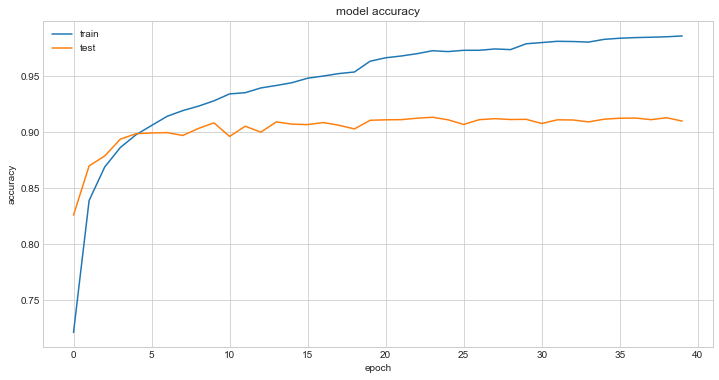

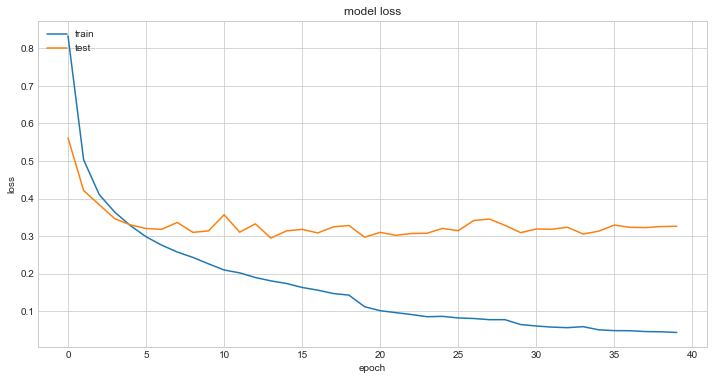

In [212]:
# summarize history for accuracy
plt.figure(figsize=(12,6))
plt.plot(history7.history['acc'])
plt.plot(history7.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.figure(figsize=(12,6))
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()